In [1]:
# General
import pandas as pd
import numpy as np
from dfply import *

# Formatting Text
import re
import string

# Text Analysis
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import spacy
import en_core_web_lg
from spacy import displacy
import textacy

# Plotting
import matplotlib.pyplot as plt
from datetime import date
import networkx as nx

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import urllib
import requests
import matplotlib.pyplot as plt

In [2]:
frame = pd.read_csv("GenConfTalks.csv")
frame.fillna("NA", inplace = True)

In [3]:
Date = []
for m, y in zip(frame.Month, frame.Year):
    Date.append(date(y, m, 1))
frame['Date'] = Date

In [4]:
grouped_ = frame.groupby(['Date']).count()
grouped_.insert(0, 'ID', range(100, 100 + len(grouped_)))
frame.set_index(['Date'], inplace=True)

In [5]:
frame = pd.merge(frame, grouped_[['ID']], right_on='Date', left_index=True)
frame.reset_index(inplace = True)

In [6]:
stop = list(set(stopwords.words("english"))) + list([x for x in string.punctuation])
printable = set(string.printable)

In [7]:
def tokening(text): 
    token = word_tokenize(text)
    token = [word.lower() for word in token if word not in stop]
    return token

In [8]:
frame['Sentence'] = frame['Talk'].apply(lambda x: sent_tokenize(x))
frame['Tokens'] = frame['Talk'].apply(lambda x: tokening(x))
frame.head()

,Date,Year,Month,Speaker,Role,Title,Talk,ID,Sentence,Tokens
0,2019-04-01,2019,4,Ulisses Soares,Of the Quorum of the Twelve Apostles,How Can I Understand?,"My dear brothers and sisters, what a great joy...",196,"[My dear brothers and sisters, what a great jo...","[my, dear, brothers, sisters, great, joy, toge..."
1,2019-04-01,2019,4,Becky Craven,Second Counselor in the Young Women General Pr...,Careful versus Casual,"I once saw a sign in a store window that said,...",196,[I once saw a sign in a store window that said...,"[i, saw, sign, store, window, said, happiness,..."
2,2019-04-01,2019,4,Brook P. Hales,Of the Seventy,Answers to Prayer,An important and comforting doctrine of the go...,196,[An important and comforting doctrine of the g...,"[an, important, comforting, doctrine, gospel, ..."
3,2019-04-01,2019,4,Dieter F. Uchtdorf,Of the Quorum of the Twelve Apostles,Missionary Work: Sharing What Is in Your Heart,Last month the Twelve were invited by our dear...,196,[Last month the Twelve were invited by our dea...,"[last, month, twelve, invited, dear, prophet, ..."
4,2019-04-01,2019,4,W. Christopher Waddell,Second Counselor in the Presiding Bishopric,Just as He Did,"Approximately 18 months ago, in the fall of 20...",196,"[Approximately 18 months ago, in the fall of 2...","[approximately, 18, months, ago, fall, 2017, 6..."


In [9]:
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
def lemm_tokes(texts):
    lems = [wn.lemmatize(text) for text in texts]
    return lems

def stem_tokes(texts):
    lems = [ps.stem(text) for text in texts]
    return lems

In [10]:
frame['Lem_Tokens'] = frame['Tokens'].apply(lambda x: lemm_tokes(x))
frame['Stem_Tokens'] = frame['Tokens'].apply(lambda x: stem_tokes(x))
frame['POS'] = frame['Tokens'].apply(lambda x: nltk.pos_tag(x))

In [14]:
ID = []
POS = []
Word = []
for i, item in enumerate(frame['POS']):
    for x in item:
        ID.append(196 - i)
        POS.append(x[1])
        Word.append(x[0])
pos = pd.DataFrame({"ID":ID, "POS":POS, "Word":Word})
pos.head()

,ID,POS,Word
0,196,PRP$,my
1,196,JJ,dear
2,196,NNS,brothers
3,196,NNS,sisters
4,196,JJ,great


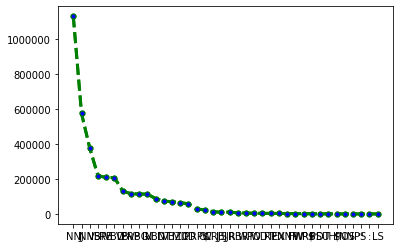

          ID     Word
POS                  
NN   1132562  1132562
JJ    575901   575901
NNS   377145   377145
VBP   218619   218619
RB    208833   208833


In [15]:
plt.plot(pos.groupby('POS').count().sort_values('Word', ascending=False),
         color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=5)
plt.show()
print(pos.groupby('POS').count().sort_values('Word', ascending=False).head())

In [16]:
frame.info()
frame.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3839 entries, 0 to 3838
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         3839 non-null   object
 1   Year         3839 non-null   int64 
 2   Month        3839 non-null   int64 
 3   Speaker      3839 non-null   object
 4   Role         3839 non-null   object
 5   Title        3839 non-null   object
 6   Talk         3839 non-null   object
 7   ID           3839 non-null   int32 
 8   Sentence     3839 non-null   object
 9   Tokens       3839 non-null   object
 10  Lem_Tokens   3839 non-null   object
 11  Stem_Tokens  3839 non-null   object
 12  POS          3839 non-null   object
dtypes: int32(1), int64(2), object(10)
memory usage: 375.0+ KB


,Date,Year,Month,Speaker,Role,Title,Talk,ID,Sentence,Tokens,Lem_Tokens,Stem_Tokens,POS
0,2019-04-01,2019,4,Ulisses Soares,Of the Quorum of the Twelve Apostles,How Can I Understand?,"My dear brothers and sisters, what a great joy...",196,"[My dear brothers and sisters, what a great jo...","[my, dear, brothers, sisters, great, joy, toge...","[my, dear, brother, sister, great, joy, togeth...","[my, dear, brother, sister, great, joy, togeth...","[(my, PRP$), (dear, JJ), (brothers, NNS), (sis..."
1,2019-04-01,2019,4,Becky Craven,Second Counselor in the Young Women General Pr...,Careful versus Casual,"I once saw a sign in a store window that said,...",196,[I once saw a sign in a store window that said...,"[i, saw, sign, store, window, said, happiness,...","[i, saw, sign, store, window, said, happiness,...","[i, saw, sign, store, window, said, happi, 15,...","[(i, NN), (saw, VBD), (sign, NN), (store, NN),..."
2,2019-04-01,2019,4,Brook P. Hales,Of the Seventy,Answers to Prayer,An important and comforting doctrine of the go...,196,[An important and comforting doctrine of the g...,"[an, important, comforting, doctrine, gospel, ...","[an, important, comforting, doctrine, gospel, ...","[an, import, comfort, doctrin, gospel, jesu, c...","[(an, DT), (important, JJ), (comforting, NN), ..."
3,2019-04-01,2019,4,Dieter F. Uchtdorf,Of the Quorum of the Twelve Apostles,Missionary Work: Sharing What Is in Your Heart,Last month the Twelve were invited by our dear...,196,[Last month the Twelve were invited by our dea...,"[last, month, twelve, invited, dear, prophet, ...","[last, month, twelve, invited, dear, prophet, ...","[last, month, twelv, invit, dear, prophet, pre...","[(last, JJ), (month, NN), (twelve, VBD), (invi..."
4,2019-04-01,2019,4,W. Christopher Waddell,Second Counselor in the Presiding Bishopric,Just as He Did,"Approximately 18 months ago, in the fall of 20...",196,"[Approximately 18 months ago, in the fall of 2...","[approximately, 18, months, ago, fall, 2017, 6...","[approximately, 18, month, ago, fall, 2017, 64...","[approxim, 18, month, ago, fall, 2017, 64-year...","[(approximately, RB), (18, CD), (months, NNS),..."


In [17]:
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    analyzer = SentimentIntensityAnalyzer()
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = analyzer.polarity_scores(sentence) 
      
    #print("Overall sentiment dictionary is : ", sentiment_dict) 
    #print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
    #print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
    #print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
    
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        result = "Positive"
    elif sentiment_dict['compound'] <= - 0.05 : 
        result = "Negative" 
    else : 
        result = "Neutral"
        
    return sentiment_dict['compound']

def scoring(sents):
    scores = []
    for i in range(len(sents)):
        num = sentiment_scores(sents[i])
        scores.append(num)
    x = sum(scores)/len(scores)
    return x

In [18]:
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)
 

In [19]:
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix


def generate_summary(sentences, top_n=5):
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)

    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    

    for i in range(top_n):
      summarize_text.append("".join(ranked_sentence[i][1]))

    # Step 5 - Offcourse, output the summarize texr
    return summarize_text

In [20]:
index = 77
print(generate_summary(frame['Sentence'][index], 3))

['So perhaps I could have reasonably thought that President Monson s words were for someone else.', 'Instead, the attribute and spiritual gift of meekness with which he was blessed attenuated arrogance in his life and magnified Moses as an instrument to accomplish God s purposes.', 'Whereas humility generally denotes dependence upon God and the constant need for His guidance and support, a distinguishing characteristic of meekness is a particular spiritual receptivity to learning both from the Holy Ghost and from people who may seem less capable, experienced, or educated, who may not hold important positions, or who otherwise may not appear to have much to contribute.']


In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(frame['Talk'])

In [22]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 7
number_words = 10
# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [23]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
love family church help women home children sisters time need

Topic #1:
church lord god people shall world welfare work day members

Topic #2:
lord god christ jesus father know faith church gospel holy

Topic #3:
said lord great church young years time president day people

Topic #4:
priesthood president church quorum presidency general members manifest sustain authority

Topic #5:
family children priesthood temple lord church god young home work

Topic #6:
god life jesus christ lord shall father man unto said


In [24]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
from os import path

LDAvis_data_filepath = path.join('./ldavis_prepared')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
print(LDAvis_prepared)

if 1 == 0:
    with open(LDAvis_data_filepath, 'w') as f:
            pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath) as f:
        LDAvis_prepared = pickle.load(f)
        

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.063607 -0.005472       1        1  26.287586
6     -0.127956 -0.063609       2        1  18.898429
3     -0.019199  0.073289       3        1  16.668933
0     -0.038941  0.103160       4        1  14.299273
5     -0.024088  0.029007       5        1  10.421539
1     -0.023557 -0.118996       6        1   9.388645
4      0.297349 -0.017379       7        1   4.035595, topic_info=             Term          Freq         Total Category  logprob  loglift
30166  priesthood   9610.000000   9610.000000  Default  30.0000  30.0000
7881       church  22447.000000  22447.000000  Default  29.0000  29.0000
30066   president  10850.000000  10850.000000  Default  28.0000  28.0000
15083      family  11067.000000  11067.000000  Default  27.0000  27.0000
7674     children  12341.000000  12341.000000  Default  26.0000  26.0000
...           ...           ...  

In [25]:
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

In [42]:
def calling_group(text):
    x = "NA"
    if re.search('First Presidency', text) or re.search('President of the Church', text):
        x = 'First Presidency'
    elif re.search('Twelve', text):
        x = 'Quorum of the Twelve'
    elif re.search('Seventy', text):
        x = "Quorum of the Seventy"
    elif re.search('Primary', text):
        x = "Primary"
    elif re.search('Young Men', text):
        x = "Young Men"
    elif re.search('Young Women', text):
        x = "Young Women"
    elif re.search('Relief', text):
        x = "Relief Society"
    elif re.search('Sunday School', text):
        x = "Sunday School"
    elif re.search('Bishop', text):
        x = "Bishopric"
    return x

In [47]:
frame['GroupedRole'] = frame['Role'].apply(lambda x: calling_group(x))

**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************
**********************************************************************************************************


In [49]:
nlp = en_core_web_lg.load()

In [50]:
text = "".join(frame['Sentence'][6])
doc = nlp(text)

In [51]:
def summary(doc):
    summary = ''
    ent_list = []
    
    for e in doc.ents:
        if e.label_ == "PERSON":
            ent_list.append(str(e).lower().strip())
            
    ent_list = list( dict.fromkeys(ent_list) )
    
    for ent in ent_list:
        sentences = textacy.extract.semistructured_statements(doc, ent)
        for statement in sentences:
            subject, verb, fact = statement
            if len(fact) > 1:
                print(ent)
                print(" - Fact: ", fact)
    return summary

In [52]:
summary(doc)

''

def print_ents(doc):
    sentence_spans = list(doc.sents)
    displacy.render(sentence_spans, style="ent")
    
print_ents(doc)

In [65]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF

vectorizer = TfidfVectorizer(stop_words='english',analyzer='word', max_features=8000)
x_counts = vectorizer.fit_transform(frame["Talk"]);

transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [66]:
num_topics = 9

#obtain a NMF model.
model = NMF(n_components=num_topics, init='nndsvd');
#fit the model
model.fit(xtfidf_norm)

def get_nmf_topics(model):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [67]:
dframe = get_nmf_topics(model)

In [68]:
dframe

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,na,proposed,god,auditing,emeritus,rededicated,uplifted,auditing,priesthood
1,hunt,favor,lord,audit,statistical,statistical,constituted,budgets,relief
2,fiery,manifest,shall,department,branches,31,authorities,certified,society
3,tutoring,opposed,ye,audits,territories,issued,manifest,assets,women
4,griefs,sustain,christ,controlled,statistics,december,favor,policies,family
5,sufferings,counselor,unto,accounting,31,operation,proposed,expenditures,church
6,bags,seventies,jesus,expenditures,seventy,mexico,general,departments,young
7,furnace,release,book,departments,wards,status,officers,audits,home
8,sicknesses,vote,ghost,financial,december,dedicated,changes,funds,welfare
9,realities,seventy,father,funds,issued,fort,opposed,approved,missionary
